In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/GraphRL_v2/')

Mounted at /content/drive


In [2]:
#@title Imports

!pip install networkx==2.6.3
import networkx as nx
import itertools
from functools import lru_cache
import random
import numpy as np
import numpy.matlib
from numpy import inf, ix_
import time
import copy
from copy import deepcopy
import time
from typing import NamedTuple
from tqdm import tqdm
import glob
import json

import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.rcParams["animation.html"] = "jshtml"

import os

import torch # get version using torch.__version__ for PyG wheels
import torch.nn as nn
import torch.nn.functional as F
os.environ['TORCH'] = torch.__version__

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric import utils, transforms

!pip install -q Cython
!pip install -q Ripser

from ripser import ripser

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.3 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 2.8.8
    Uninstalling networkx-2.8.8:
      Successfully uninstalled networkx-2.8.8
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 57.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 KB 10.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 KB 5.0 MB/s eta 0:00:00
  Pre

In [3]:
#@title Environments

@lru_cache(maxsize = 100000)
def get_NX_subgraph(frozen_set_of_nodes, graph_NX):

  return graph_NX.subgraph(list(frozen_set_of_nodes))

@lru_cache(maxsize = 500000)
def get_PyG_subgraph(frozen_set_of_nodes, graph_NX):

  subgraph_NX = get_NX_subgraph(frozen_set_of_nodes, graph_NX)
  subgraph_PyG = utils.from_networkx(subgraph_NX, group_node_attrs = all)

  return subgraph_PyG

@lru_cache(maxsize = 100000)
def compute_feature_value(feature_function, graph_NX):

  return feature_function(graph_NX)

@lru_cache(maxsize = 100000)
def get_neighbors(frozen_set_of_nodes, graph_NX):
  """
  Returns the neighborhood of a set of nodes.
  """

  nodes = list(frozen_set_of_nodes)
  all_neighbors = set()

  for node in nodes:
    neighbors = set([n for n in graph_NX.neighbors(node)])
    all_neighbors.update(neighbors) 
    
  all_neighbors = all_neighbors - set(nodes) # remove input nodes from their own neighborhood

  return list(all_neighbors)

class GraphEnvironment():
  
  def __init__(self, ID, graph_NX, steps_per_episode, feature):
    super().__init__()

    self.ID = ID # identifier for the environment

    self.graph_NX = graph_NX # environment graph (NetworkX Graph object)  
    self.steps_per_episode = steps_per_episode
    self.num_nodes = self.graph_NX.number_of_nodes()
    self.visited = [random.choice(list(self.graph_NX.nodes()))] # store a list of visited nodes
    self.state_NX = get_NX_subgraph(frozenset(self.visited), self.graph_NX)
    self.feature_function = feature # handle to network feature-of-interest
    
  def step(self, action):
    """
    Execute an action in the environment, i.e. visit a new node.
    """

    assert action in self.get_actions(self.visited), "Invalid action!"
    self.visited = self.visited + [action] # add new node to list of visited nodes
    self.state_NX = get_NX_subgraph(frozenset(self.visited), self.graph_NX)
    reward = self.compute_reward()
    terminal = self.is_terminal()

    return self.get_state_dict(), reward, terminal, self.get_info()

  def unstep(self):
    """
    Undo the most recent action. Multiple calls will undo multiple actions.
    """

    self.visited = self.visited[:-1] # remove most recently visited node
    self.state_NX = get_NX_subgraph(frozenset(self.visited), self.graph_NX)

    return self.get_state_dict(), self.get_info()
  
  def is_terminal(self):

    case_1 = len(self.visited) == self.steps_per_episode
    case_2 = len(self.visited) == self.num_nodes
    
    return bool(case_1 or case_2)

  def compute_reward(self):
    
    return compute_feature_value(self.feature_function, self.state_NX)

  def reset(self):
    """
    Reset to initial state.
    """

    self.visited = [random.choice(list(self.graph_NX.nodes()))] # empty the list of visited nodes
    self.state_NX = get_NX_subgraph(frozenset(self.visited), self.graph_NX)
    terminal = False

    return self.get_state_dict(), terminal, self.get_info()

  def get_state_dict(self):

    return {'visited': self.visited, 
            'state_NX': self.state_NX}
      
  def get_info(self):

    return {'environment_ID': self.ID, # useful for DQN training
            'feature_value': compute_feature_value(self.feature_function, self.state_NX)}
  
  def get_actions(self, visited_nodes):
    """ 
    Returns available actions given a list of visited nodes.
    """

    # get neighbors of most recently visited node
    actions = get_neighbors(frozenset(visited_nodes[-1:]), self.graph_NX)
    # remove the set of already visited nodes
    actions = set(actions) - set(visited_nodes)
    # if no neighbors are available to visit then allow jumps to distant nodes
    if not actions: 
      actions = set(self.graph_NX.nodes()) - set(visited_nodes)

    return list(actions)
  
  def render(self):
    """
    Render current state to the screen.
    """

    plt.figure()
    nx.draw(self.state_NX, with_labels = True)

class MultipleEnvironments():

  def __init__(self, environments):
    
    self.environments = environments
    self.num_environments = len(self.environments)

  def reset(self):

    state_dicts = []
    terminals = []
    all_info = []

    for environment in self.environments:
      state_dict, terminal, info = environment.reset()
      state_dicts.append(state_dict)
      terminals.append(terminal)
      all_info.append(info)

    return state_dicts, terminals, all_info
  
  def step(self, actions):

    state_dicts = []
    rewards = []
    terminals = []
    all_info = []

    for idx, environment in enumerate(self.environments):
      state_dict, reward, terminal, info = environment.step(actions[idx])
      state_dicts.append(state_dict)
      rewards.append(reward)
      terminals.append(terminal)
      all_info.append(info)

    return state_dicts, rewards, terminals, all_info
  
  def __len__(self):
    return self.num_environments

In [4]:
#@title Baseline Agents

class RandomAgent():
  """
  RandomAgent() chooses an action at random. The agent is not deterministic.
  """
  
  def __init__(self):
    super().__init__()
    
    self.environments = None # should be instance of MultipleEnvironments() class
    self.is_trainable = False # useful to manage control flow during simulations

  def choose_action(self):

    if not self.environments:
      assert False, "Supply environment(s) for the agent to interact with."

    actions = []

    for environment in self.environments.environments:
      available_actions = environment.get_actions(environment.visited)
      action = random.choice(available_actions)
      actions.append(action)

    return actions

class HighestDegreeAgent():
  """
  HighestDegreeAgent() chooses the action with the highest node degree. The 
  agent is deterministic.
  """

  def __init__(self):
    super().__init__()

    self.environments = None # should be instance of MultipleEnvironments() class
    self.is_trainable = False # useful to manage control flow during simulations

  def choose_action(self):

    if not self.environments:
      assert False, "Supply environment(s) for the agent to interact with."

    actions = []

    for environment in self.environments.environments:
      available_actions = environment.get_actions(environment.visited)
      all_degrees = list(zip(*(environment.graph_NX.degree(available_actions))))[1]
      action_idx = all_degrees.index(max(all_degrees)) # first largest when ties
      action = available_actions[action_idx]
      actions.append(action)

    return actions

class LowestDegreeAgent():
  """
  LowestDegreeAgent() chooses the action with the lowest node degree. The 
  agent is deterministic.
  """

  def __init__(self):
    super().__init__()

    self.environments = None # should be instance of MultipleEnvironments() class
    self.is_trainable = False # useful to manage control flow during simulations

  def choose_action(self):

    if not self.environments:
      assert False, "Supply environment(s) for the agent to interact with."

    actions = []

    for environment in self.environments.environments:
      available_actions = environment.get_actions(environment.visited)
      all_degrees = list(zip(*(environment.graph_NX.degree(available_actions))))[1]
      action_idx = all_degrees.index(min(all_degrees)) # first smallest when ties
      action = available_actions[action_idx]
      actions.append(action)

    return actions

class GreedyAgent():
  """
  GreedyAgent() chooses the action that would result in the greatest reward.
  The agent uses a copy of the environment to simulate each available action and 
  returns the best performing action. The agent is deterministic.
  """

  def __init__(self):
    super().__init__()

    self.environments = None # should be instance of MultipleEnvironments() class
    self.is_trainable = False # useful to manage control flow during simulations

  def choose_action(self):

    if not self.environments:
      assert False, "Supply environment(s) for the agent to interact with."

    actions = []

    for environment in self.environments.environments:
      available_actions = environment.get_actions(environment.visited)
      best_reward = float('-inf')
      best_action = None

      for action in available_actions:
        state_dict, reward, terminal, info = environment.step(action)

        if reward > best_reward:
          best_reward = reward
          best_action = action
        
        environment.unstep() # undo the action

      actions.append(best_action)

    return actions

In [5]:
#@title DQN Agent

class GNN(nn.Module):

  def __init__(self, hyperparameters):
    super().__init__()
    
    self.conv1 = SAGEConv(
        hyperparameters['num_node_features'],
        hyperparameters['GNN_latent_dimensions'],
        aggr = 'mean')
    self.conv2 = SAGEConv(
        hyperparameters['GNN_latent_dimensions'],
        hyperparameters['GNN_latent_dimensions'],
        aggr = 'mean')
    self.conv3 = SAGEConv(
        hyperparameters['GNN_latent_dimensions'],
        hyperparameters['embedding_dimensions'],
        aggr = 'mean')

  def forward(self, x, edge_index, batch = None):

    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    x = F.relu(x) 
    x = self.conv3(x, edge_index)
    x = F.relu(x) # node embeddings
    x = torch_geometric.nn.global_add_pool(x, batch = batch) # graph embedding

    return x

class QN(nn.Module):

  def __init__(self, hyperparameters):
    super().__init__()

    self.fc1 = nn.Linear(hyperparameters['embedding_dimensions'], 
                         hyperparameters['QN_latent_dimensions'])
    self.fc2 = nn.Linear(hyperparameters['QN_latent_dimensions'], 1)

  def forward(self, x):

    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)

    return x

class DQNAgent():

  def __init__(self, embedding_module, q_net, 
               replay_buffer, train_start, batch_size, learn_every,
               optimizer, 
               epsilon, epsilon_decay_rate, epsilon_min):
    super().__init__()

    self.environments = None # should be instance of MultipleEnvironments() class
    self.is_trainable = True # useful to manage control flow during simulations
    
    self.embedding_module = embedding_module
    self.q_net = q_net
    
    self.target_embedding_module = deepcopy(embedding_module)
    self.target_q_net = deepcopy(q_net)
    
    # disable gradients for target networks
    for parameter in self.target_embedding_module.parameters():
      parameter.requires_grad = False

    for parameter in self.target_q_net.parameters():
      parameter.requires_grad = False
    
    self.replay_buffer = replay_buffer
    self.train_start = train_start # specify burn-in period
    self.batch_size = batch_size
    self.learn_every = learn_every # steps between updates to target nets

    self.optimizer = optimizer

    self.epsilon = epsilon # probability with which to select a non-greedy action
    self.epsilon_decay_rate = epsilon_decay_rate
    self.epsilon_min = epsilon_min

    self.step = 0

  def choose_action(self):
    """
    Choose an action to perform for each environment in self.environments.
    """

    if not self.environments:
      assert False, "Supply environment(s) for the agent to interact with."

    actions = []

    for environment in self.environments.environments:
      available_actions = environment.get_actions(environment.visited)
      new_subgraphs = [] # list to store all possible next states

      for action in available_actions:
        visited_nodes_new = environment.visited + [action]
        new_subgraph = get_PyG_subgraph(frozenset(visited_nodes_new), environment.graph_NX)
        new_subgraphs.append(new_subgraph)

      # create a batch to allow for a single forward pass
      batch = Batch.from_data_list(new_subgraphs)

      # gradients for the target networks are disabled
      with torch.no_grad(): # redundant because gradients are already disabled
        q_values = self.target_q_net(self.target_embedding_module(batch.x, 
                                                                  batch.edge_index, 
                                                                  batch.batch))
      if torch.rand(1) < self.epsilon: # explore
        action = np.random.choice(available_actions)
      else: # exploit
        action_idx = torch.argmax(q_values).item()
        action = available_actions[action_idx]

      actions.append(action)

    return actions

  def train(self, state_dicts, actions, next_state_dicts, rewards, discounts, all_info):

    self.replay_buffer.add(state_dicts, actions, next_state_dicts, rewards, discounts, all_info)
    self.step += 1
    
    if self.step < self.train_start: # inside the burn-in period
      return 

    # (1) Get lists of experiences from memory
    states, actions, next_states, rewards, discounts, all_info = self.replay_buffer.sample(self.batch_size)
    
    # (2) Build state + action = new_subgraph (technically identical to next state)
    new_subgraphs = []
    for idx, state_dict in enumerate(states):
      visited_nodes_new = state_dict['visited'] + [actions[idx]]
      assert visited_nodes_new == next_states[idx]['visited'], "train() assertion failed."
      new_subgraph = get_PyG_subgraph(frozenset(visited_nodes_new), 
                                      self.environments.environments[all_info[idx]['environment_ID']].graph_NX)
      new_subgraphs.append(new_subgraph)

    batch = Batch.from_data_list(new_subgraphs)

    # (3) Pass batch of next_state subgraphs through ANN to get predicted q-values
    q_predictions = self.q_net(self.embedding_module(batch.x, 
                                                     batch.edge_index, 
                                                     batch.batch))

    # (4) Compute target q-values for batch
    q_targets = []
    for idx, next_state_dict in enumerate(next_states):
      available_actions = self.environments.environments[all_info[idx]['environment_ID']].get_actions(next_state_dict['visited'])

      if available_actions: # terminal states have no available actions, redundant in a lot of settings

        new_subgraphs = [] # each available action results in a new state

        for action in available_actions:
          visited_nodes_new = next_state_dict['visited'] + [action]
          new_subgraph = get_PyG_subgraph(frozenset(visited_nodes_new), 
                                          self.environments.environments[all_info[idx]['environment_ID']].graph_NX)
          new_subgraphs.append(new_subgraph)

        batch = Batch.from_data_list(new_subgraphs)

        with torch.no_grad(): # technically, no_grad() is unnecessary
          q_target = self.target_q_net(self.target_embedding_module(batch.x, 
                                                                    batch.edge_index, 
                                                                    batch.batch))
          q_target = q_target.max().view(-1, 1) # get the largest next q-value
          q_target = rewards[idx] + discounts[idx] * q_target
          q_targets.append(q_target)

      else:
        q_targets.append(rewards[idx])

    q_targets = torch.Tensor(q_targets).view(-1, 1)
      
    # (5) Compute MSE loss between predicted and target q-values
    loss = F.mse_loss(q_predictions, q_targets).mean()

    # (6) Backpropagate gradients
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # (7) Copy parameters from source to target networks
    if self.step % self.learn_every == 0: 
      copy_parameters_from_to(self.embedding_module, self.target_embedding_module)
      copy_parameters_from_to(self.q_net, self.target_q_net)
      
    # (8) Decrease exploration rate
    self.epsilon *= self.epsilon_decay_rate
    self.epsilon = max(self.epsilon, self.epsilon_min)

    return loss.item() # for logging

In [6]:
#@title Helper Functions: Miscellaneous

def initialize_weights(m):
  """
  Xavier initialization of model weights.
  """

  if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
    m.weight.data.fill_(1.0)
    m.bias.data.zero_()

  elif isinstance(m, SAGEConv):
    m.lin_l.weight.data = nn.init.xavier_uniform_(
        m.lin_l.weight.data, gain = nn.init.calculate_gain('relu'))
    
    if m.lin_l.bias is not None:
      m.lin_l.bias.data.zero_()

    m.lin_r.weight.data = nn.init.xavier_uniform_(
        m.lin_r.weight.data, gain = nn.init.calculate_gain('relu'))
    
    if m.lin_r.bias is not None: # redundant
      m.lin_r.bias.data.zero_()

  elif isinstance(m, nn.Linear):
    m.weight.data = nn.init.xavier_uniform_(
        m.weight.data, gain = nn.init.calculate_gain('relu'))
    
    if m.bias is not None:
      m.bias.data.zero_()

def compute_Frobenius_norm(network):
    """
    Compute the Frobenius norm of all network tensors.
    """
    norm = 0.0

    for name, param in network.named_parameters():
        norm += torch.norm(param).data  
               
    return norm.item()

def copy_parameters_from_to(source_network, target_network):
  """
  Update the parameters of the target network by copying values from the source
  network.
  """

  for source, target in zip(source_network.parameters(), target_network.parameters()):
    target.data.copy_(source.data)

  return

def average_area_under_the_curve(all_feature_values):
  """
  Returns the average area under the curve given a list of list of feature 
  values. Each list inside all_feature_values corresponds to an environment. 
  Each list inside that list corresponds to an episode. Each element of the 
  inner list is a feature value at a given step during an episode.
  """

  all_areas = []
  for env_results in all_feature_values:
    areas = [sum(feature_values) for feature_values in env_results]
    all_areas.append(sum(areas)/len(areas))
  
  return sum(all_areas)/len(all_areas)

def generate_video(plotting_dict):

  feature_values_random = plotting_dict['random']
  feature_values_degree = plotting_dict['degree']
  feature_values_greedy = plotting_dict['greedy']
  feature_values_DQN = np.array(plotting_dict['DQN'])

  xlim = feature_values_DQN.shape[1]
  x = np.arange(xlim) # number of nodes

  ylim = max(max(feature_values_random), 
             max(feature_values_degree), 
             max(feature_values_greedy), 
             np.max(feature_values_DQN))

  fig, ax = plt.subplots()
  ax.axis([0, xlim, 0, ylim + 0.01 * ylim])

  line1, = ax.plot(x, feature_values_random, label = 'random', color = 'blue')
  line2, = ax.plot(x, feature_values_degree, label = 'max degree', color = 'orange')
  line3, = ax.plot(x, feature_values_greedy, label = 'greedy', color = 'green')
  line4, = ax.plot([], [], label = 'DQN', color = 'black')

  ax.legend()

  plt.xlabel('Step')
  plt.ylabel('Value')

  def animate(i):
    line4.set_data(x, feature_values_DQN[i])
    
  anim_handle = animation.FuncAnimation(fig, animate, 
                                        frames = len(feature_values_DQN),
                                        interval = 100,  
                                        blit = False, repeat = False, 
                                        repeat_delay = 10000)
  plt.close() # do not show extra figure

  return anim_handle

def node_featurizer(graph_NX, mode = 'LDP'):

  graph_NX = deepcopy(graph_NX)

  attributes = {}

  for node in graph_NX.nodes():
    
    node_attributes = {}

    if mode == 'LDP':

      neighborhood = list(set([n for n in graph_NX.neighbors(node)]))

      if neighborhood:
        neighborhood_degrees = list(map(list, zip(*graph_NX.degree(neighborhood))))[1]
      else: # no neighbors
        neighborhood_degrees = [0]

      node_attributes['feature_1'] = graph_NX.degree(node)
      node_attributes['feature_2'] = min(neighborhood_degrees)
      node_attributes['feature_3'] = max(neighborhood_degrees)
      node_attributes['feature_4'] = float(np.mean(neighborhood_degrees))
      node_attributes['feature_5'] = float(np.std(neighborhood_degrees))

    if mode == 'random':

      node_attributes['feature_1'] = random.random()
      node_attributes['feature_2'] = random.random()
      node_attributes['feature_3'] = random.random()
      node_attributes['feature_4'] = random.random()
      node_attributes['feature_5'] = random.random()

    if mode == 'constant':

      node_attributes['feature_1'] = 1.0
      node_attributes['feature_2'] = 1.0
      node_attributes['feature_3'] = 1.0
      node_attributes['feature_4'] = 1.0
      node_attributes['feature_5'] = 1.0

    attributes[node] = node_attributes
    
  nx.set_node_attributes(graph_NX, attributes)

  return graph_NX

def node_defeaturizer(graph_NX):

  graph_NX = deepcopy(graph_NX)

  attrs = set([k for n in graph_NX.nodes for k in graph_NX.nodes[n].keys()])

  for (n, d) in graph_NX.nodes(data = True):

    for attr in attrs:
      del d[attr]

  return graph_NX

class ReplayBuffer():
  
  def __init__(self, buffer_size):

    self.buffer_size = buffer_size
    self.ptr = 0 # index to latest experience in memory
    self.num_experiences = 0 # number of experiences stored in memory
    self.states = [None] * self.buffer_size
    self.actions = [None] * self.buffer_size
    self.next_states = [None] * self.buffer_size
    self.rewards = [None] * self.buffer_size
    self.discounts = [None] * self.buffer_size
    self.all_info = [None] * self.buffer_size

  def add(self, state_dicts, actions, next_state_dicts, rewards, discounts, all_info):

    # check if arguments are lists
    if not isinstance(state_dicts, list): # i.e. a single experience
      state_dicts = [state_dicts]
      actions = [actions]
      next_state_dicts = [next_state_dicts]
      rewards = [rewards]
      discounts = [discounts]
      all_info = [all_info]

    for i in range(len(state_dicts)):
      self.states[self.ptr] = state_dicts[i]
      self.actions[self.ptr] = actions[i]
      self.next_states[self.ptr] = next_state_dicts[i]
      self.rewards[self.ptr] = rewards[i]
      self.discounts[self.ptr] = discounts[i]
      self.all_info[self.ptr] = all_info[i]
      
      if self.num_experiences < self.buffer_size:
        self.num_experiences += 1

      self.ptr = (self.ptr + 1) % self.buffer_size 
      # if (ptr + 1) exceeds buffer size then begin overwriting older experiences

  def sample(self, batch_size):      

    indices = np.random.choice(self.num_experiences, batch_size)   
    states = [self.states[index] for index in indices] 
    actions = [self.actions[index] for index in indices] 
    next_states = [self.next_states[index] for index in indices] 
    rewards = [self.rewards[index] for index in indices] 
    discounts = [self.discounts[index] for index in indices] 
    all_info = [self.all_info[index] for index in indices] 
    
    return states, actions, next_states, rewards, discounts, all_info

def save_checkpoint(embedding_module, q_net, 
                    optimizer, 
                    replay_buffer, 
                    returns, feature_values_train,
                    validation_steps, validation_scores, feature_values_val,
                    step,
                    save_path):
  
  save_dict = {'embedding_module_state_dict': embedding_module.state_dict(),
               'q_net_state_dict': q_net.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'buffer_ptr': replay_buffer.ptr,
               'buffer_num_experience': replay_buffer.num_experiences,
               'buffer_states': replay_buffer.states,
               'buffer_actions': replay_buffer.actions,
               'buffer_next_states': replay_buffer.next_states,
               'buffer_rewards': replay_buffer.rewards,
               'buffer_discounts': replay_buffer.discounts,
               'buffer_all_info': replay_buffer.all_info,
               'returns': returns,
               'feature_values_train': feature_values_train,
               'validation_steps': validation_steps,
               'validation_scores': validation_scores,
               'feature_values_val': feature_values_val,
               'step': step}

  torch.save(save_dict, save_path)

def load_checkpoint(load_path, embedding_module, q_net, 
                    optimizer = None, 
                    replay_buffer = None):
  
  checkpoint = torch.load(load_path)

  embedding_module.load_state_dict(checkpoint['embedding_module_state_dict'])
  q_net.load_state_dict(checkpoint['q_net_state_dict'])

  if optimizer:
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

  if replay_buffer:
    replay_buffer.ptr = checkpoint['buffer_ptr']
    replay_buffer.num_experiences = checkpoint['buffer_num_experience']
    replay_buffer.states = checkpoint['buffer_states']
    replay_buffer.actions = checkpoint['buffer_actions']
    replay_buffer.next_states = checkpoint['buffer_next_states']
    replay_buffer.rewards = checkpoint['buffer_rewards']
    replay_buffer.discounts = checkpoint['buffer_discounts']
    replay_buffer.all_info = checkpoint['buffer_all_info']

  returns = checkpoint['returns']
  feature_values_train = checkpoint['feature_values_train']
  validation_steps = checkpoint['validation_steps']
  validation_scores = checkpoint['validation_scores']
  feature_values_val = checkpoint['feature_values_val']

  train_log = {'returns': returns,
               'feature_values_train': feature_values_train}

  val_log = {'validation_steps': validation_steps,
             'validation_scores': validation_scores,
             'feature_values_val': feature_values_val}

  return train_log, val_log

In [7]:
#@title Helper Functions: Simulation

def simulate(agent, environments, num_episodes = 100, verbose = True):
  """
  Simulate agent in multiple environments for a specified number of episodes.
  This function assumes that episodes in each environment have the same number 
  of steps.
  """

  agent = deepcopy(agent)
  agent.environments = environments 

  all_feature_values = [[] for _ in range(environments.num_environments)]

  state_dicts, terminals, all_info = environments.reset()

  pbar = tqdm(range(num_episodes), unit = 'Episode', disable = not verbose)

  for _ in pbar:
    episode_feature_values = [[] for _ in range(environments.num_environments)]

    while not any(terminals):
      assert any(terminals) == all(terminals), "Simulation error!"
      actions = agent.choose_action() # choose an action for each environment
      state_dicts, rewards, terminals, all_info = environments.step(actions)
      episode_feature_values.append(all_info)

      for idx, info in enumerate(all_info):
        episode_feature_values[idx].append(info['feature_value'])
        
    for idx, terminal in enumerate(terminals):
      if terminal: # this should always be true when control is here
        all_feature_values[idx].append(episode_feature_values[idx])
    
    state_dicts, terminals, all_info = environments.reset()

  return all_feature_values

def learn_environments(agent, train_environments, val_environments, 
                       num_steps, discount_factor, val_every,
                       save_folder = None,
                       log_val_results = True, verbose = True):
  """
  Train agent on multiple environments by simulating agent-environment 
  interactions for a specified number of steps.
  """

  agent.environments = train_environments # supply the agent with environments

  # training logs
  all_episode_returns_train = [[] for _ in range(train_environments.num_environments)]
  all_episode_feature_values_train = [[] for _ in range(train_environments.num_environments)]
  episode_returns_train = [0] * train_environments.num_environments
  episode_feature_values_train = [[] for _ in range(train_environments.num_environments)]

  # validation logs
  all_episode_feature_values_val = []
  if not val_environments: 
    log_val_results = False
  val_steps = []
  val_scores = []
  val_score = -float('inf')

  state_dicts, terminals, all_info = train_environments.reset()

  pbar = tqdm(range(num_steps), unit = 'Step', disable = not verbose)

  for step in pbar:
    actions = agent.choose_action() # choose an action for each environment
    next_state_dicts, rewards, terminals, all_info = train_environments.step(actions)
    episode_returns_train = [sum(x) for x in zip(rewards, episode_returns_train)]

    for idx, info in enumerate(all_info):
      episode_feature_values_train[idx].append(info['feature_value'])

    if agent.is_trainable:
      discounts = [discount_factor * (1 - terminal) for terminal in terminals]
      loss = agent.train(state_dicts, actions, next_state_dicts, rewards, discounts, all_info)
      
      if log_val_results and step % val_every == 0: # evaluate validation performance 
        all_feature_values_val = simulate(agent, val_environments,
                                          num_episodes = 10, verbose = False)
        val_score = average_area_under_the_curve(all_feature_values_val)
        val_steps.append(step)
        val_scores.append(val_score)
        all_episode_feature_values_val.append(all_feature_values_val)

        if save_folder is not None: # save checkpoint
          save_path = os.path.join(save_folder, 'model_' + str(step) + '.pt')
          save_checkpoint(agent.embedding_module, agent.q_net, 
                          agent.optimizer,
                          agent.replay_buffer,
                          all_episode_returns_train, all_episode_feature_values_train,
                          val_steps, val_scores, all_episode_feature_values_val, 
                          step, 
                          save_path)       

      if loss: 
        pbar.set_description('Loss: %0.5f, Val. Score: %0.5f' % (loss, val_score))

      else: # no loss value is returned inside the burn-in period
        pbar.set_description('Loss: %0.5f, Val. Score: %0.5f' % (float('inf'), val_score))

    state_dicts = next_state_dicts

    for idx, terminal in enumerate(terminals):
      # if terminal then gather episode results for this environment and reset
      if terminal: 
        all_episode_returns_train[idx].append(episode_returns_train[idx])
        episode_returns_train[idx] = 0
        all_episode_feature_values_train[idx].append(episode_feature_values_train[idx])
        episode_feature_values_train[idx] = []
        state_dict, terminal, info = train_environments.environments[idx].reset()
        state_dicts[idx] = state_dict

  train_environments.reset()

  train_log = {'returns': all_episode_returns_train,
               'feature_values_train': all_episode_feature_values_train}

  # validate final model and save checkpoint
  all_feature_values_val = simulate(agent, val_environments,
                                    num_episodes = 10, verbose = False)
  val_score = average_area_under_the_curve(all_feature_values_val)
  val_steps.append(num_steps)
  val_scores.append(val_score)
  all_episode_feature_values_val.append(all_feature_values_val)

  if save_folder is not None: # save checkpoint
    save_path = os.path.join(save_folder, 'model_' + str(num_steps) + '.pt')
    save_checkpoint(agent.embedding_module, agent.q_net, 
                    agent.optimizer,
                    agent.replay_buffer,
                    all_episode_returns_train, all_episode_feature_values_train,
                    val_steps, val_scores, all_episode_feature_values_val, 
                    num_steps, 
                    save_path)

  val_log = {'validation_steps': val_steps,
             'validation_scores': val_scores,
             'feature_values_val': all_episode_feature_values_val}

  return train_log, val_log

In [8]:
#@title Helper Functions: Rewards

def make_filtration_matrix(G):
    """
    Takes in adjacency matrix and returns a filtration matrix for Ripser
    """

    N = G.shape[0]
    weighted_G = np.ones([N, N])
    for col in range(N):
        weighted_G[:col, col] = weighted_G[:col, col] * col
        weighted_G[col, :col] = weighted_G[col, :col] * col
    weighted_G += 1 # pushes second node's identifier to 2
    # removes diagonals, simultaneously resetting first node's identifier to 0
    weighted_G = np.multiply(G, weighted_G) 
    # place 1 to N along the diagonal
    np.fill_diagonal(weighted_G, list(range(1, N + 1)))
    # set all zeros to be non-edges (i.e. at inf distance)
    weighted_G[weighted_G == 0] = np.inf
    # remove 1 from everywhere to ensure first node has identifier 0
    weighted_G -= 1
    
    return weighted_G

def betti_numbers(G, maxdim = 2, dim = 1):
  """
  Given a NetworkX graph object, computes number of topological cycles 
  (i.e. Betti numbers) of various dimensions upto maxdim.
  """

  adj = nx.to_numpy_array(G)
  adj[adj == 0] = np.inf # set unconnected nodes to be infinitely apart
  np.fill_diagonal(adj, 1) # set diagonal to 1 to indicate all nodes are born at once
  bars = ripser(adj, distance_matrix = True, maxdim = maxdim)['dgms'] # returns barcodes
  bars_list = list(zip(range(maxdim + 1), bars))
  bettis_dict = dict([(dim, len(cycles)) for (dim, cycles) in bars_list])

  return bettis_dict[dim] # return Betti number for dimension of interest

def get_barcode(filt_mat, maxdim = 2):
    """
    Calculates the persistent homology for a given filtration matrix
    ``filt_mat``, default dimensions 0 through 2. Wraps ripser.
    """

    b = ripser(filt_mat, distance_matrix = True, maxdim = maxdim)['dgms']

    return list(zip(range(maxdim + 1), b))

def betti_curves(bars, length):
    """
    Takes in bars and returns the betti curves
    """

    bettis = np.zeros((len(bars), length))

    for i in range(bettis.shape[0]):
        bn = bars[i][1]

        for bar in bn:
            birth = int(bar[0])
            death = length+1 if np.isinf(bar[1]) else int(bar[1]+1)
            bettis[i][birth:death] += 1

    return bettis

def plot_bettis(bettis):
  
  N = bettis.shape[1]
  colors = ['xkcd:emerald green', 'xkcd:tealish', 'xkcd:peacock blue']
  
  for i in range(3):
    plt.plot(list(range(N)), bettis[i], color = colors[i], 
             label = '$\\beta_{}$'.format(i), 
             linewidth = 1)
  plt.xlabel('Nodes')
  plt.ylabel('Number of Cycles')
  plt.legend()

TOL = 1E-8

def repmat(M, m, n):
    return np.transpose(np.matlib.repmat(np.array([M]), m, n))

def rate_distortion_upper_info(G, setting = 1):

    assert setting == 1, "Only setting 1 available."
    assert np.all(np.abs(G - G.T) < TOL), "Network must be symmetric."

    # network size
    N = len(G)
    E  = np.sum(G)/2

    # variables to save
    S = np.zeros((N)) # upper bound on entropy rate after clustering
    S_low = np.zeros((N)) # lower bound on entropy rate
    clusters = [[] for i in range(N)] # clusters[n] lists the nodes in each of the n clusters
    Gs = [[] for i in range(N)] # Gs[n] is the joint transition probability matrix for n clusters

    P_old = numpy.divide(G, np.transpose(np.matlib.repmat(np.array([np.sum(G, 1)]), N, 1)))

    # compute steady-state probabilities (works for undirected and possibly disconnected networks)
    p_ss = np.sum(G, 1)/np.sum(G)
    p_ss_old = copy.copy(p_ss)

    # compute initial entropy
    logP_old = np.log2(P_old, where = P_old > 0)
    logP_old[logP_old == -inf] = 0
    S_old = -np.sum(np.multiply(p_ss_old, np.sum(np.multiply(P_old, logP_old), 1)))
    P_joint = np.multiply(P_old, np.transpose(np.matlib.repmat(p_ss_old, N, 1)))
    P_low = P_old

    # record initial values
    S[-1] = S_old
    S_low[-1] = S_old
    clusters[-1] = [[i] for i in range(N)]
    Gs[-1] = G

    for n in reversed(range(2, N)):
        pairs = np.array(list(itertools.combinations([k for k in range(1, n + 2)], 2)))
        I = pairs[:, 0]
        J = pairs[:, 1]

        # number of pairs
        num_pairs_temp = len(I)

        # track all entropies
        S_all = np.zeros((num_pairs_temp))

        for ind in range(num_pairs_temp):
                i = I[ind]
                j = J[ind]
                inds_not_ij = [v - 1 for v in  list(range(1, i)) + list(range(i + 1, j)) + list(range(j + 1, n + 2))]

                # compute new stationary distribution
                p_ss_temp = [p_ss_old[inds_not_ij], p_ss_old[i - 1] + p_ss_old[j - 1]]
                
                # compute new transition probabilities
                P_temp_1 = np.sum(np.multiply(repmat(p_ss_old[inds_not_ij], 2, 1), P_old[ix_(inds_not_ij, [i - 1, j - 1])] ), 1)
                P_temp_1 = np.divide(P_temp_1, p_ss_temp[:-1])

                P_temp_2 = np.sum(np.multiply(repmat(p_ss_old[[i - 1, j - 1]].T, n - 1, 1), P_old[ix_([i - 1, j - 1], inds_not_ij)]), 0)
                P_temp_2 = P_temp_2/p_ss_temp[-1]
            
                P_temp_3 = np.sum(np.sum(np.multiply(repmat(p_ss_old[[i - 1, j - 1]], 2, 1), P_old[ ix_([i - 1, j - 1], [i - 1, j - 1])])))
                P_temp_3 = P_temp_3/p_ss_temp[-1]

                logP_temp_1 = np.log2(P_temp_1, where = P_temp_1 > 0)
                logP_temp_1[logP_temp_1 == -inf] = 0
                logP_temp_2 = np.log2(P_temp_2, where = P_temp_2 > 0)
                logP_temp_2[logP_temp_2 == -inf] = 0
                logP_temp_3 = np.array(np.log2(P_temp_3, where = P_temp_3 > 0))
                logP_temp_3[logP_temp_3 == -inf] = 0

                # compute change in upper bound on mutual information
                dS = - np.sum(np.multiply(np.multiply(p_ss_temp[:-1], P_temp_1), logP_temp_1))  
                dS = dS - p_ss_temp[-1] * np.sum(np.multiply(P_temp_2, logP_temp_2))
                dS = dS - p_ss_temp[-1] * P_temp_3 * logP_temp_3 
                dS = dS + np.sum(np.multiply(np.multiply(p_ss_old, P_old[:, i - 1]), logP_old[:, i - 1]))
                dS = dS + np.sum(np.multiply(np.multiply(p_ss_old, P_old[:, j - 1]), logP_old[:, j - 1]))
                dS = dS + p_ss_old[i - 1] * np.sum(np.multiply(P_old[i - 1, :], logP_old[i - 1, :]))
                dS = dS + p_ss_old[j - 1] * np.sum(np.multiply(P_old[j - 1, :], logP_old[j - 1, :]))
                dS = dS - p_ss_old[i - 1] * (P_old[i - 1, i - 1] * logP_old[i - 1, i - 1] + P_old[i - 1, j - 1] * logP_old[i - 1, j - 1]) 
                dS = dS - p_ss_old[j - 1] * (P_old[j - 1, j - 1] * logP_old[j - 1, j - 1] + P_old[j - 1, i - 1] * logP_old[j - 1, i - 1]) 
                
                S_temp = S_old + dS

                # track all entropies
                S_all[ind] = S_temp

        # find minimum entropy
        min_inds = np.where(S_all == min(S_all))
        iidx = random.randint(0, len(min_inds[0]) - 1)
        min_ind = [min_inds[0][iidx]]

        # save mutual information
        S_old = S_all[min_ind]
        S[n - 1] = S_old
        
        i_new = I[min_ind][0]
        j_new = J[min_ind][0]
        inds_not_ij = [v - 1 for v in list(range(1, i_new)) + list(range(i_new + 1, j_new)) + list(range(j_new + 1, n + 2))]
        p_ss_new = numpy.concatenate((p_ss_old[inds_not_ij], np.array([p_ss_old[i_new - 1] + p_ss_old[j_new - 1]])))
      
        P_joint = np.multiply(repmat(p_ss_old.T, n + 1, 1), P_old)
        AB = P_joint[ix_(inds_not_ij, inds_not_ij)]
        A = np.expand_dims(np.sum(P_joint[ix_(inds_not_ij, [i_new - 1, j_new - 1])], 1), 1)
        B = np.expand_dims(np.sum(P_joint[ix_([i_new - 1, j_new - 1], inds_not_ij)], 0), 0)
        C = np.sum(np.sum(P_joint[ix_([i_new - 1, j_new - 1], [i_new - 1, j_new - 1])]))
        P_joint = np.block([[AB, A], [B, C]])

        P_old = np.divide(P_joint, repmat(p_ss_new.T, n, 1))
        p_ss_old = p_ss_new

        logP_old = np.log2(P_old, where = P_old > 0)
        logP_old[logP_old == -inf] = 0

        # record clusters and graph
        cls1_ind = [v - 1 for v in list(range(1, (i_new))) + list(range((i_new), (j_new - 1))) + list(range((j_new), (n + 1)))]
        cls1 = [clusters[n][v] for v in  cls1_ind]
        cls2 = [list(clusters[n][i_new - 1]) + list(clusters[n][j_new - 1])]
        clusters[n - 1] = cls1 + cls2
        Gs[n - 1] = P_joint * 2 * E
        sp = numpy.expand_dims(P_low[:, i_new - 1] + P_low[:, j_new - 1], 1)
        P_low = np.concatenate((P_low[:, cls1_ind], sp), 1)
        logP_low = np.log2(P_low, where = P_low > 0)
        logP_low[logP_low == -inf] = 0
        S_low[n-1] = -np.sum(np.multiply(p_ss, np.sum(np.multiply(P_low, logP_low), 1)))
    
    return S, S_low, clusters, Gs

def compressibility(graph_NX):
  """
  Computes network compressibility given a NetworkX graph object.
  """

  graph_NX_copy = nx.Graph(graph_NX) # make an unfrozen copy
  for node in graph_NX_copy.nodes(): # add self-loops
    graph_NX_copy.add_edge(node, node)
  G = nx.to_numpy_array(graph_NX_copy)
  S, S_low, clusters, Gs = rate_distortion_upper_info(G)
  C = np.mean(S[-1] - S)

  return C

In [9]:
#@title Parameters from Darvariu et al. 

# Data
# |G_train| = 10000
# |G_val| = 100
# |G_test| = 100

# Model
# 3 message passing rounds
# 128 hidden units in MLP
# linear exploration decay from 1 to 0.1 for steps/2 and then 0.1  

# Training
# steps = 40000 (*1 or *2 or *5)
# gamma = 1 (finite horizon)
# learn_every = 50
# weights initialized using Glorot scheme
# learning rate = 0.0001
# rewards scaled by 100

In [30]:
base_path = '/content/drive/My Drive/GraphRL_v2/'

network_type = 'wikipedia' # wikipedia, synthetic_ER, synthetic_BA
size = 'small' # size of dataset

feature = betti_numbers # betti_numbers, compressibility

In [31]:
#@title Load baseline results

baselines_path = os.path.join(base_path, 'Baselines/')
save_filename = baselines_path + network_type + '_' + size + '_' + feature.__name__ + '_baselines.json'

with open(save_filename, 'r') as f:
  baseline_agents_load = json.load(f)

random_agent_train = baseline_agents_load['random']['train']
max_degree_agent_train = baseline_agents_load['max_degree']['train']
min_degree_agent_train = baseline_agents_load['min_degree']['train']
greedy_agent_train = baseline_agents_load['greedy']['train']

feature_values_mean_random_train = np.mean(np.mean(np.array(random_agent_train), axis = 0), axis = 0)
feature_values_mean_max_degree_train = np.mean(np.mean(np.array(max_degree_agent_train), axis = 0), axis = 0)
feature_values_mean_min_degree_train = np.mean(np.mean(np.array(min_degree_agent_train), axis = 0), axis = 0)
feature_values_mean_greedy_train = np.mean(np.mean(np.array(greedy_agent_train), axis = 0), axis = 0)

random_agent_val = baseline_agents_load['random']['val']
max_degree_agent_val = baseline_agents_load['max_degree']['val']
min_degree_agent_val = baseline_agents_load['min_degree']['val']
greedy_agent_val = baseline_agents_load['greedy']['val']

feature_values_mean_random_val = np.mean(np.mean(np.array(random_agent_val), axis = 0), axis = 0)
feature_values_mean_max_degree_val = np.mean(np.mean(np.array(max_degree_agent_val), axis = 0), axis = 0)
feature_values_mean_min_degree_val = np.mean(np.mean(np.array(min_degree_agent_val), axis = 0), axis = 0)
feature_values_mean_greedy_val = np.mean(np.mean(np.array(greedy_agent_val), axis = 0), axis = 0)

random_agent_test = baseline_agents_load['random']['test']
max_degree_agent_test = baseline_agents_load['max_degree']['test']
min_degree_agent_test = baseline_agents_load['min_degree']['test']
greedy_agent_test = baseline_agents_load['greedy']['test']

feature_values_mean_random_test = np.mean(np.mean(np.array(random_agent_test), axis = 0), axis = 0)
feature_values_mean_max_degree_test = np.mean(np.mean(np.array(max_degree_agent_test), axis = 0), axis = 0)
feature_values_mean_min_degree_test = np.mean(np.mean(np.array(min_degree_agent_test), axis = 0), axis = 0)
feature_values_mean_greedy_test = np.mean(np.mean(np.array(greedy_agent_test), axis = 0), axis = 0)

In [32]:
#@title Load DQN results

DQN_path = base_path + network_type + '_' + size + '_' + feature.__name__ + '_run_' + run
save_filename = os.path.join(DQN_path, 'log.json')

with open(save_filename, 'r') as f:
  log = json.load(f)

before_training = log['before_training']
train_log = log['train_log']
val_log = log['val_log']

In [36]:
assert log['run'] == run, 'Mismatch in run ID.'
assert log['network_type'] == network_type, 'Mismatch in network type.'
assert log['size'] == size, 'Mismatch in network size.'
assert log['feature'] == feature.__name__, 'Mismatch in feature function.'

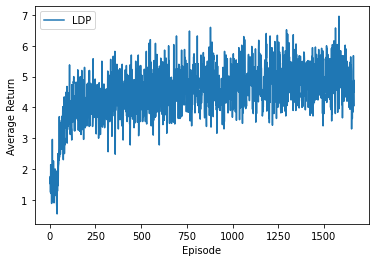

In [37]:
plt.xlabel('Episode')
plt.ylabel('Average Return')
plt.plot(np.mean(np.array(train_log['returns']), axis = 0), label = 'LDP')
plt.legend()

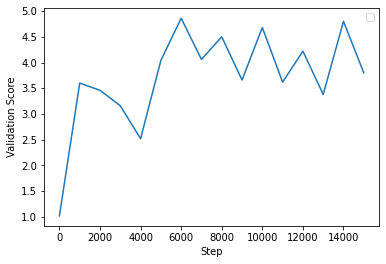

In [39]:
plt.xlabel('Step')
plt.ylabel('Validation Score')
plt.plot(val_log['validation_steps'], val_log['validation_scores'])
plt.legend()

In [40]:
#@title Load best checkpoint

hyperparameters = {'num_node_features': 5,
                   'GNN_latent_dimensions': 64,
                   'embedding_dimensions': 64,
                   'QN_latent_dimensions': 32,
                   'buffer_size': 500000,
                   'train_start': 320,
                   'batch_size': 32,
                   'learn_every': 16,
                   'epsilon_initial': 1,
                   'epsilon_min': 0.1,
                   'discount_factor': 0.75,
                   'learning_rate': 3e-4}

embedding_module = GNN(hyperparameters)
q_net = QN(hyperparameters)

max_index = np.argmax(val_log['validation_scores'])
steps = val_log['validation_steps'][max_index]
checkpoint_name = os.path.join(DQN_path, 'model_' + str(steps) + '.pt')

train_log_cpt, val_log_cpt = load_checkpoint(checkpoint_name, embedding_module, q_net)

agent = DQNAgent(embedding_module, q_net, 
                 replay_buffer = None, train_start = None, batch_size = None, 
                 learn_every = None, 
                 optimizer = None, 
                 epsilon = 0, epsilon_decay_rate = None, epsilon_min = None)

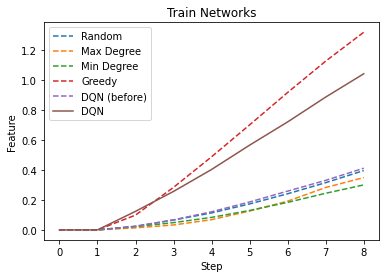

In [41]:
#@title Training performance

feature_values_mean_DQN_train_before = np.mean(np.mean(np.array(before_training), axis = 0), axis = 0)
feature_values_mean_DQN_train_after = np.mean(np.mean(np.array(train_log_cpt['feature_values_train']), axis = 0), axis = 0)

plt.title('Train Networks')
plt.xlabel('Step')
plt.ylabel('Feature')
plt.plot(feature_values_mean_random_train, label = 'Random', linestyle = 'dashed')
plt.plot(feature_values_mean_max_degree_train, label = 'Max Degree', linestyle = 'dashed')
plt.plot(feature_values_mean_min_degree_train, label = 'Min Degree', linestyle = 'dashed')
plt.plot(feature_values_mean_greedy_train, label = 'Greedy', linestyle = 'dashed')
plt.plot(feature_values_mean_DQN_train_before, label = 'DQN (before)', linestyle = 'dashed')
plt.plot(feature_values_mean_DQN_train_after, label = 'DQN')
plt.legend()

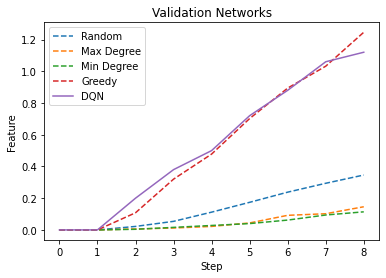

In [42]:
#@title Validation performance

feature_values_mean_DQN_val = np.mean(np.mean(np.array(val_log_cpt['feature_values_val'][-1]), axis = 0), axis = 0)

plt.title('Validation Networks')
plt.xlabel('Step')
plt.ylabel('Feature')
plt.plot(feature_values_mean_random_val, label = 'Random', linestyle = 'dashed')
plt.plot(feature_values_mean_max_degree_val, label = 'Max Degree', linestyle = 'dashed')
plt.plot(feature_values_mean_min_degree_val, label = 'Min Degree', linestyle = 'dashed')
plt.plot(feature_values_mean_greedy_val, label = 'Greedy', linestyle = 'dashed')
# plt.plot(feature_values_mean_DQN_val_before, label = 'DQN (before)', linestyle = 'dashed')
plt.plot(feature_values_mean_DQN_val, label = 'DQN')
plt.legend()

100%|██████████| 100/100 [00:14<00:00,  6.81Episode/s]


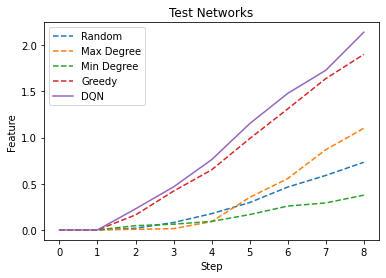

In [43]:
#@title Testing performance

env_load_path = os.path.join(base_path, 'Environments', network_type + '_' + size + '.json')

with open(env_load_path, 'r') as f:
  all_data = json.load(f)

test_data = all_data['test']

steps_per_episode = 10 # average KNOT session has ~9 unique node visits
num_episodes = 100

test_graphs = []
test_environments = []

for idx in range(len(test_data)):

  base_G = nx.node_link_graph(test_data[str(idx)])
  base_G = node_defeaturizer(base_G)
  test_graphs.append(base_G)

  G = node_featurizer(base_G, mode = 'LDP')
  environment = GraphEnvironment(idx, G, steps_per_episode, feature)
  test_environments.append(environment)

test_environments = MultipleEnvironments(test_environments)

all_feature_values = simulate(agent, test_environments, num_episodes)
feature_values_mean_DQN_test = np.mean(np.mean(np.array(all_feature_values), axis = 0), axis = 0)

plt.title('Test Networks')
plt.xlabel('Step')
plt.ylabel('Feature')
plt.plot(feature_values_mean_random_test, label = 'Random', linestyle = 'dashed')
plt.plot(feature_values_mean_max_degree_test, label = 'Max Degree', linestyle = 'dashed')
plt.plot(feature_values_mean_min_degree_test, label = 'Min Degree', linestyle = 'dashed')
plt.plot(feature_values_mean_greedy_test, label = 'Greedy', linestyle = 'dashed')
plt.plot(feature_values_mean_DQN_test, label = 'DQN')
plt.legend()